In [15]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from scipy import interpolate
import pytz

import MAMMAL
import MAMMAL.Diurnal as Diurnal
from MAMMAL.Parse import parseIM as pim
from MAMMAL.Parse import parseRaster as pr
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.Utils import ProcessingUtils as pu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)


debug = False # Set to True to enable debug printouts plus plots

# Map-Maker Initialization

In [16]:
loc_alt_msl_m    = 69 # Height of Fredericksburg above MSL
survey_alt_agl_m = 30 # Height of survey AGL
survey_alt_msl_m = loc_alt_msl_m + survey_alt_agl_m

survey = MAMMAL.MapMaker(map_loc_name = 'reconstructed_example',
                         alt_m_msl    = survey_alt_msl_m,
                         alt_m_agl    = survey_alt_agl_m,
                         data_dir     = getcwd(),
                         debug        = debug)

survey.interp_type = 'rbf'

survey.spin_fname   = join(getcwd(), r'spin_2019_9_12_0.csv')
survey.tl_fname     = join(getcwd(), r'tl_2019_9_12_0.csv')
survey.ref_fname    = join(getcwd(), r'ref_2019_9_12_0.csv')
survey.survey_fname = join(getcwd(), r'survey_2019_9_12_0.csv')

# Load Truth Map

In [17]:
TRUTH_MAP_FNAME = join(getcwd(), r'example_99m_2019_9_12_0.tiff')

truth_map = pr.parse_raster(TRUTH_MAP_FNAME)

# Find Spin Test Calibration Parameters

In [18]:
a, b = survey.spin_params()

print(a)
print(b)

[[ 9.99999999e-02  5.57695083e-10 -2.91527922e-11]
 [-2.27964052e-10  2.00000000e-01  1.30701651e-09]
 [ 2.65361785e-11  1.86757457e-08  1.00000000e+00]]
[ 0.99998747  9.99999273 20.00002557]


# Find Tolles-Lawson Calibration Parameters

In [19]:
c = survey.tl_params()

print(c)

[-2.53712549e-03  7.48175161e-03 -3.11947526e-02 -3.41711931e-07
 -3.18443778e-07  6.60171150e-07  8.37594903e-08  5.57889498e-08
 -1.99531115e-09 -2.05085081e-07 -3.78049611e-07 -4.81279418e-07
 -5.74745693e-08  1.83084903e-08 -8.09687986e-08  1.49256175e-07
 -1.30927883e-07  8.88101495e-08]


# Generate Map Using "Truth" Reference Station Data (Fredricksburg - FRD)

100%|██████████| 39204/39204 [00:02<00:00, 16934.57it/s]


Generated scalar map RMSE: 0.06657043985851316nT


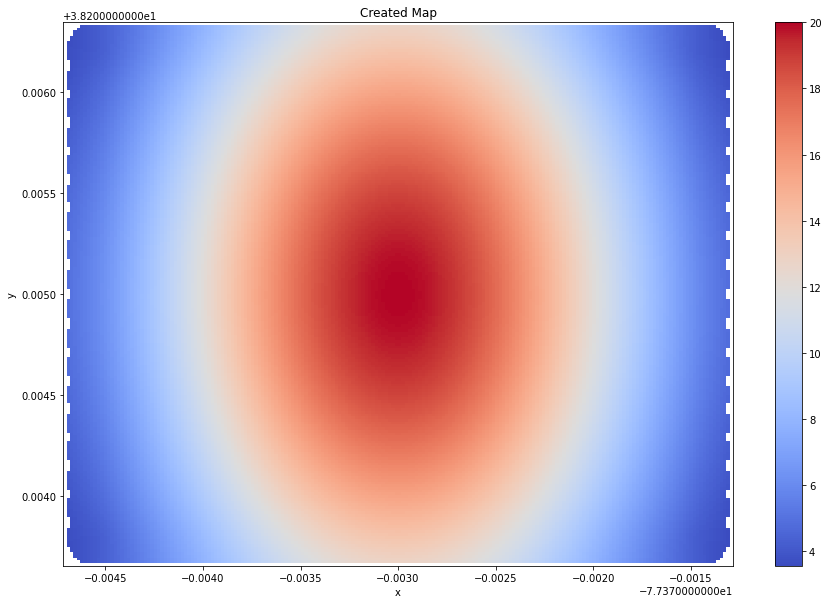

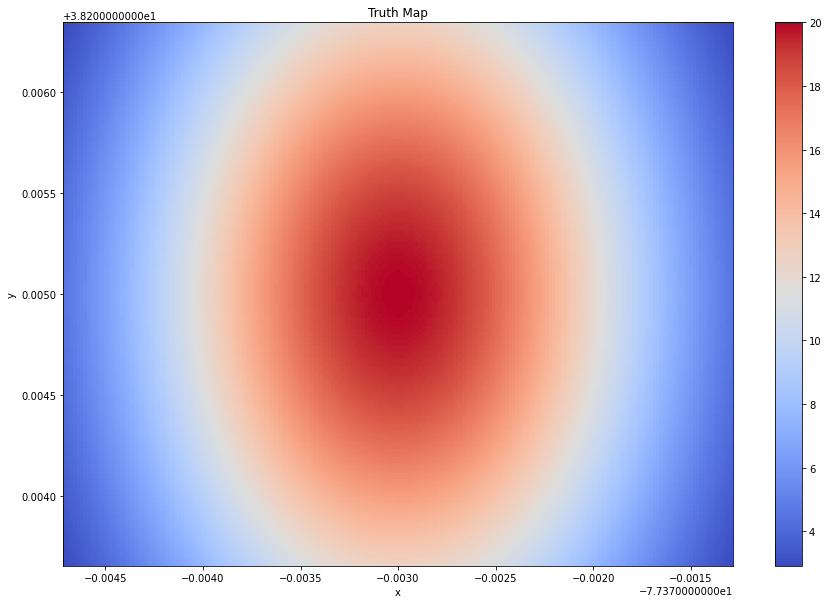

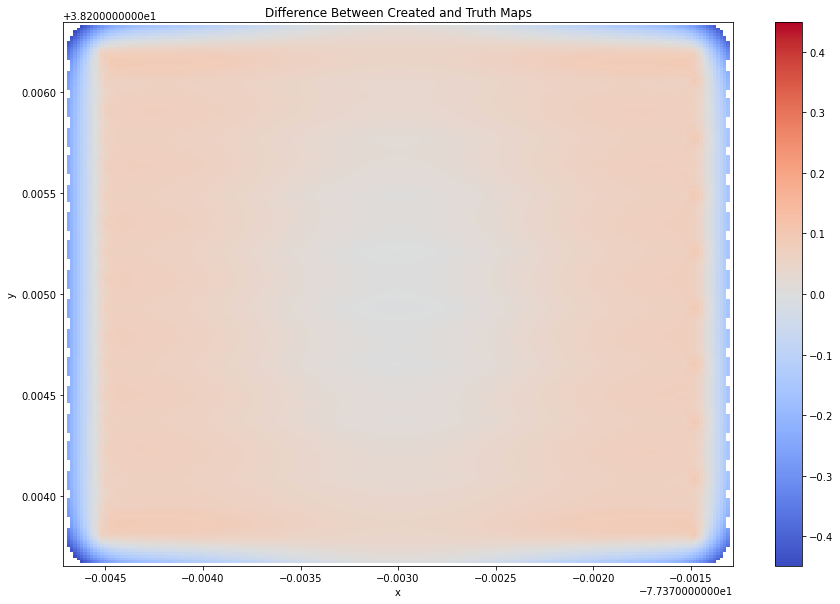

In [20]:
map = survey.gen_map()

interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

plt.figure()
interp_map.plot(cmap=cm.coolwarm)
plt.title('Created Map')

plt.figure()
truth_map[0].plot(cmap=cm.coolwarm)
plt.title('Truth Map')

plt.figure()
error_map = truth_map[mu.SCALAR] - interp_map
error_map.plot(cmap=cm.coolwarm)
plt.title('Difference Between Created and Truth Maps')

map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
print('Generated scalar map RMSE: {}nT'.format(map_rmse))

# Generate Map Without Reference Station Data

100%|██████████| 39204/39204 [00:02<00:00, 17162.57it/s]


Generated scalar map RMSE: 145.30984423308965nT


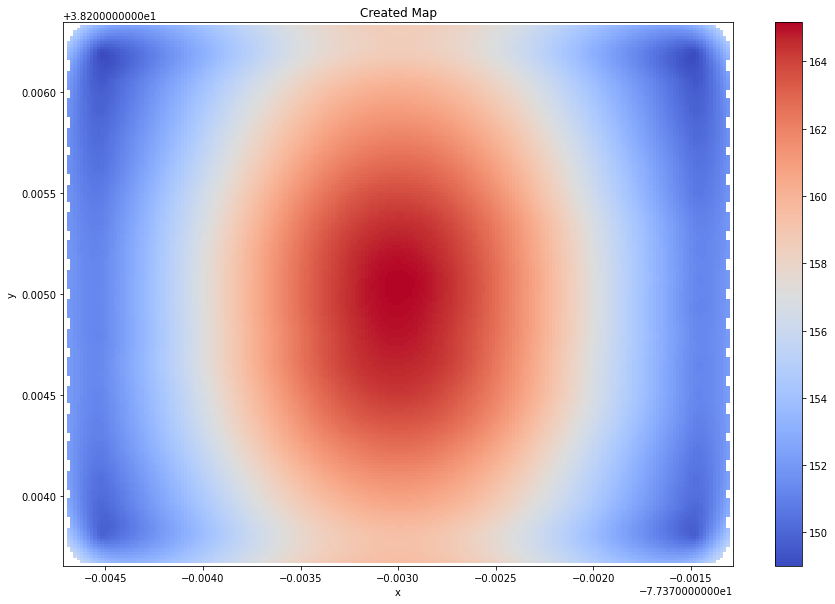

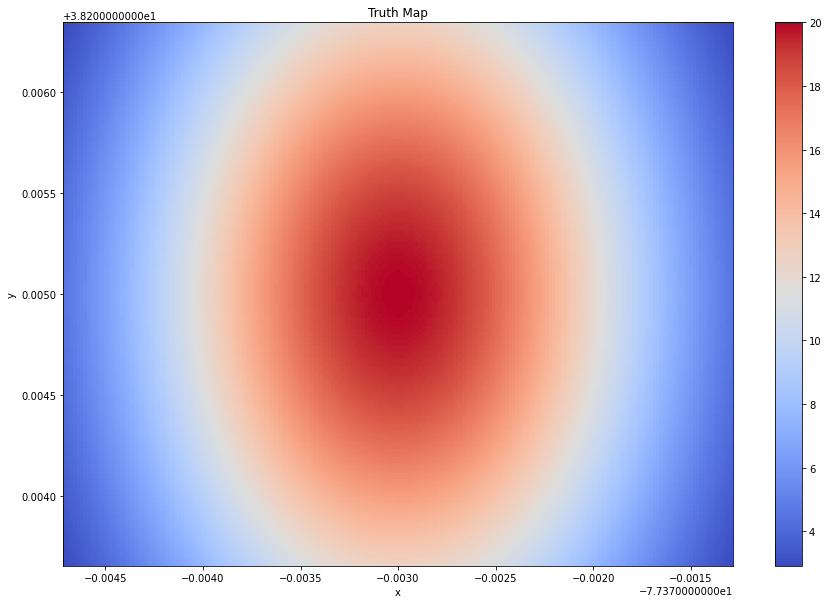

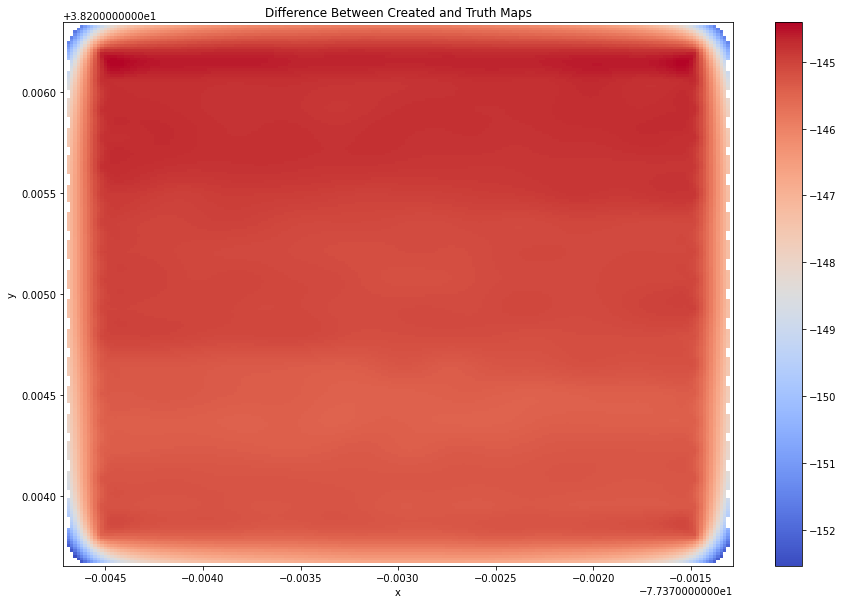

In [21]:
survey.map_loc_name = 'reconstructed_no_ref'
survey.ref_df       = None

map = survey.gen_map(ref_use_internal=True)

interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

plt.figure()
interp_map.plot(cmap=cm.coolwarm)
plt.title('Created Map')

plt.figure()
truth_map[0].plot(cmap=cm.coolwarm)
plt.title('Truth Map')

plt.figure()
error_map = truth_map[mu.SCALAR] - interp_map
error_map.plot(cmap=cm.coolwarm)
plt.title('Difference Between Created and Truth Maps')

map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
print('Generated scalar map RMSE: {}nT'.format(map_rmse))

# Generate Map Using Calibrated Reference Station Data from Boulder (BOU) - 2400km from FRD

Loaded bou20190911psec.sec
Loaded bou20190912psec.sec
Loaded frd20190911psec.sec
Loaded frd20190912psec.sec
Loaded frn20190911psec.sec
Loaded frn20190912psec.sec
Optimal scale: 0.1354037206490241
Optimal offset: 159.832254129058


100%|██████████| 39204/39204 [00:02<00:00, 16890.77it/s]


Generated scalar map RMSE: 2.286562816950017nT


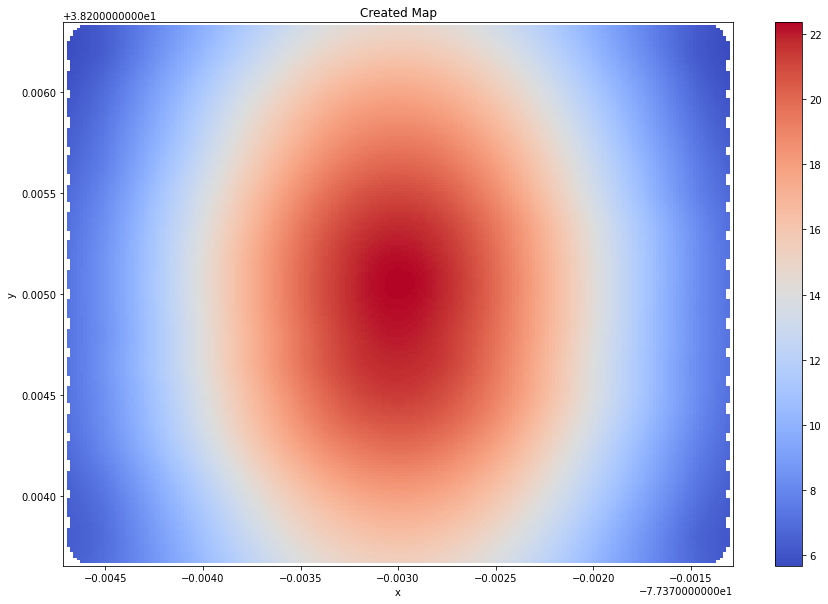

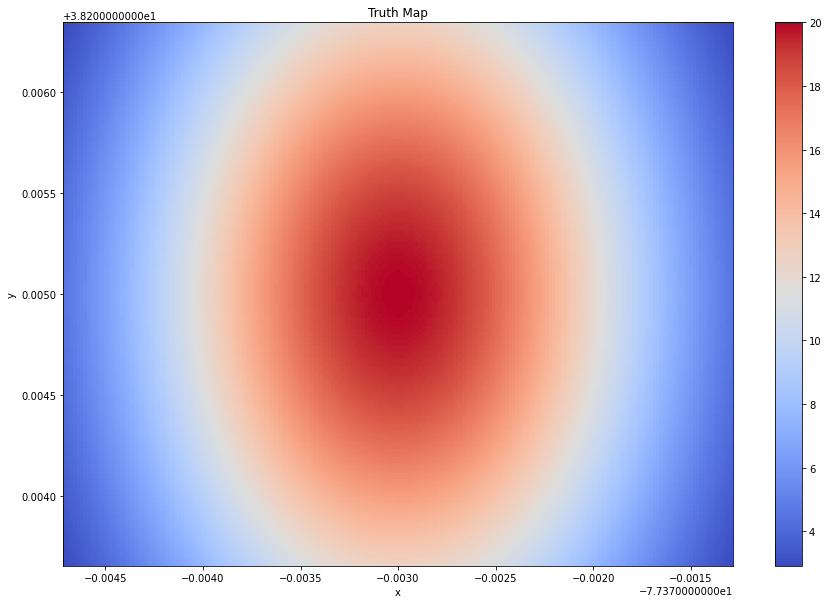

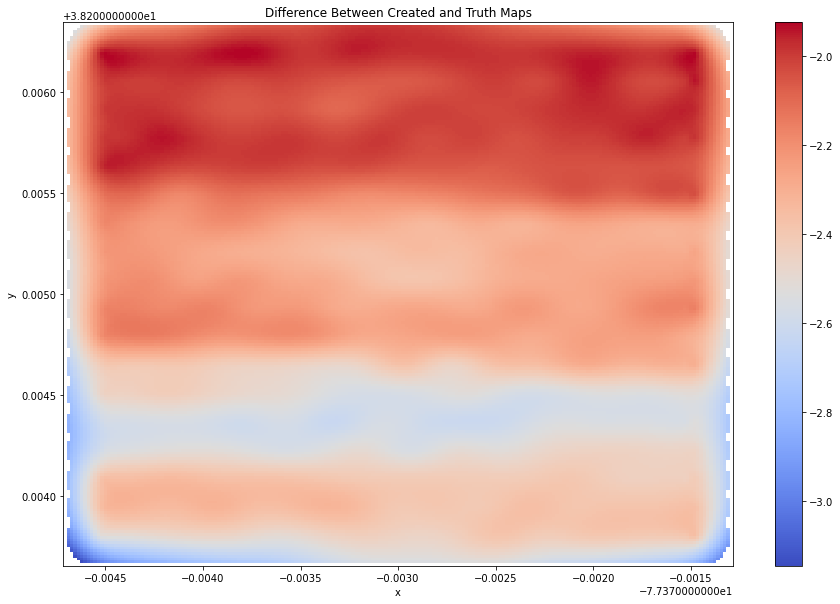

In [22]:
ref_dict = pim.loadInterMagData(TEST_DIR)

truth_ref_df = ref_dict['FRD']
bou_ref_df   = ref_dict['BOU']
frn_ref_df   = ref_dict['FRN']

truth_t         = np.array(truth_ref_df.epoch_sec)
truth_f         = np.array(truth_ref_df.F)
truth_IGRF_f    = np.array(truth_ref_df.IGRF_F)[0]
truth_f_no_core = truth_f - truth_IGRF_f

bou_t, bou_f, _, _ , _ = Diurnal.longitude_norm(bou_ref_df,
                                                truth_ref_df.LONG.mean())
bou_f_no_core = bou_f - np.array(bou_ref_df.IGRF_F)[0]

interp_combined = interpolate.interp1d(bou_t, bou_f_no_core, 'cubic')

survey_t    = np.array(survey.survey_df.epoch_sec)
interp_mask = np.logical_and(np.logical_and(truth_t >= bou_t.min(),
                                            truth_t <= bou_t.max()),
                             np.logical_and(truth_t >= (survey_t[0]  - 86400 - 2*3600),
                                            truth_t <= (survey_t[-1] - 86400 + 2*3600))) # Interpolate based on data from around the time of the survey on the previous day
interp_t    = truth_t[interp_mask] # Clip interpolation times

far_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], far_interp, truth_f_no_core[interp_mask])
far_opt_f     = Diurnal.apply_cal([offset, scale], bou_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

survey.map_loc_name = 'reconstructed_bou_ref'
survey.ref_scale    = scale
survey.ref_offset   = offset

map = survey.gen_map(ref_df=bou_ref_df)

interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

plt.figure()
interp_map.plot(cmap=cm.coolwarm)
plt.title('Created Map')

plt.figure()
truth_map[0].plot(cmap=cm.coolwarm)
plt.title('Truth Map')

plt.figure()
error_map = truth_map[mu.SCALAR] - interp_map
error_map.plot(cmap=cm.coolwarm)
plt.title('Difference Between Created and Truth Maps')

map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
print('Generated scalar map RMSE: {}nT'.format(map_rmse))

# Clean up
survey.ref_scale  = 1
survey.ref_offset = 0

# Generate Map Using Calibrated Reference Station Data from Fresno (FRN) - 4400km from FRD

Optimal scale: 0.14690255812962025
Optimal offset: 173.34683437172754


100%|██████████| 39204/39204 [00:02<00:00, 16971.40it/s]


Generated scalar map RMSE: 2.2613877196742886nT


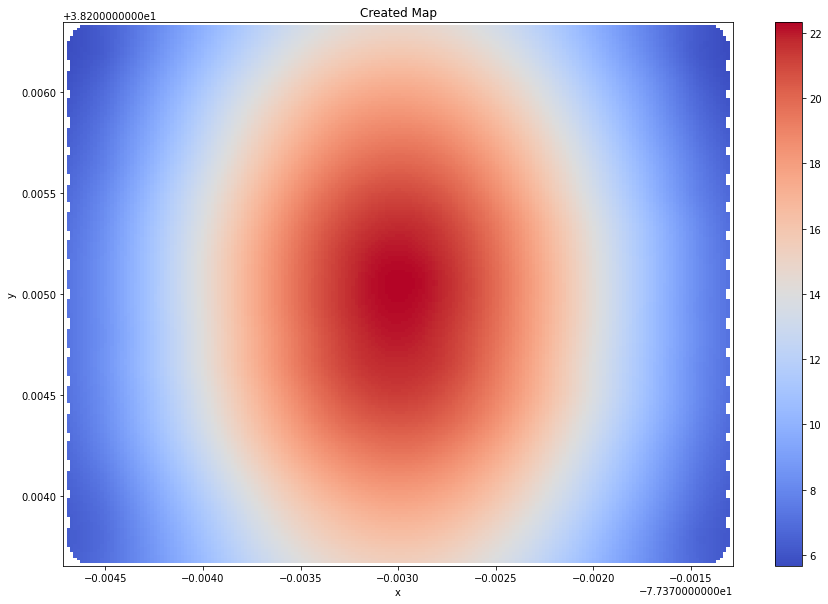

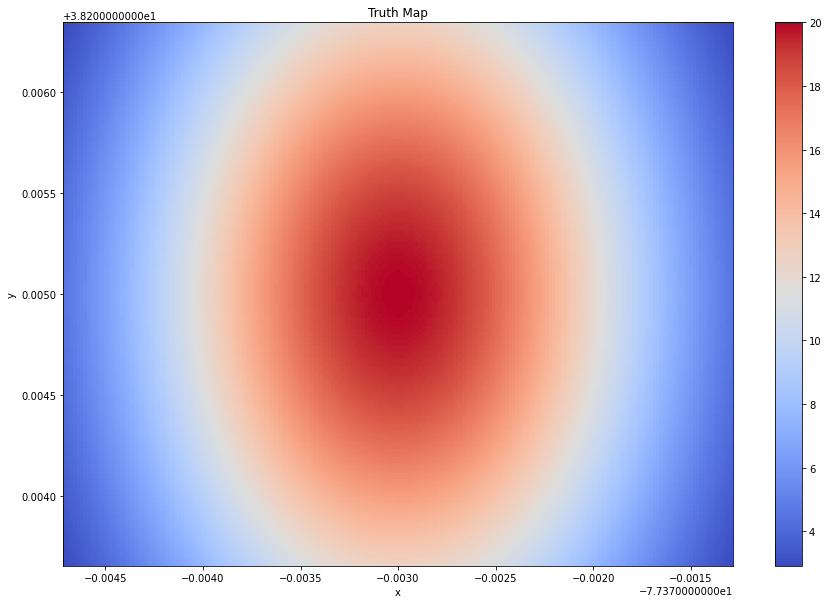

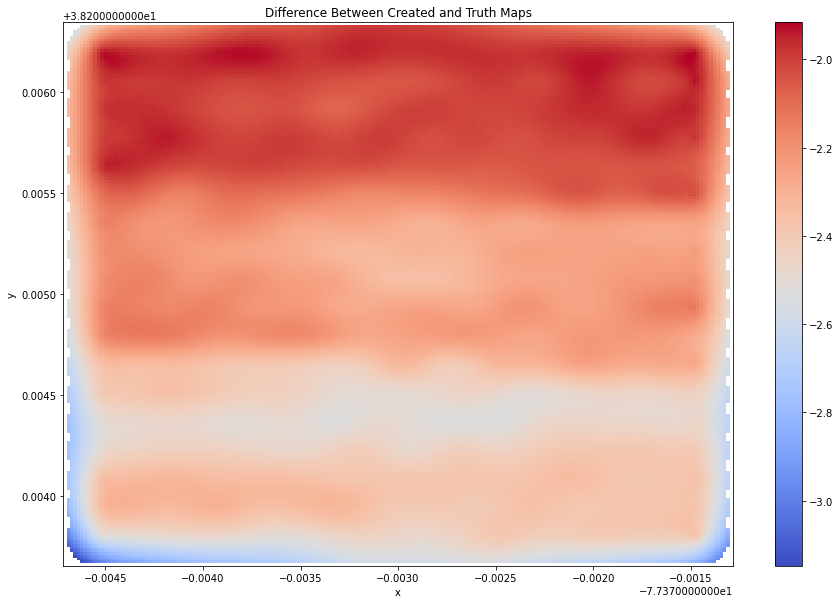

In [23]:
frn_t, frn_f, _, _ , _ = Diurnal.longitude_norm(frn_ref_df,
                                                truth_ref_df.LONG.mean())
frn_f_no_core = frn_f - np.array(frn_ref_df.IGRF_F)[0]

interp_combined = interpolate.interp1d(frn_t, frn_f_no_core, 'cubic')

survey_t    = np.array(survey.survey_df.epoch_sec)
interp_mask = np.logical_and(np.logical_and(truth_t >= bou_t.min(),
                                            truth_t <= bou_t.max()),
                             np.logical_and(truth_t >= (survey_t[0]  - 86400 - 2*3600),
                                            truth_t <= (survey_t[-1] - 86400 + 2*3600))) # Interpolate based on data from around the time of the survey on the previous day
interp_t    = truth_t[interp_mask] # Clip interpolation times

far_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], far_interp, truth_f_no_core[interp_mask])
far_opt_f     = Diurnal.apply_cal([offset, scale], frn_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

survey.map_loc_name = 'reconstructed_frn_ref'
survey.ref_scale    = scale
survey.ref_offset   = offset

map = survey.gen_map(ref_df=frn_ref_df)

interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

plt.figure()
interp_map.plot(cmap=cm.coolwarm)
plt.title('Created Map')

plt.figure()
truth_map[0].plot(cmap=cm.coolwarm)
plt.title('Truth Map')

plt.figure()
error_map = truth_map[mu.SCALAR] - interp_map
error_map.plot(cmap=cm.coolwarm)
plt.title('Difference Between Created and Truth Maps')

map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
print('Generated scalar map RMSE: {}nT'.format(map_rmse))

# Clean up
survey.ref_scale  = 1
survey.ref_offset = 0

# Generate Map Using Biased Scalar Measurements

100%|██████████| 39204/39204 [00:02<00:00, 16561.72it/s]


Generated scalar map RMSE with survey bias of 0.1nT: 0.09149344671020931nT


100%|██████████| 39204/39204 [00:02<00:00, 16775.36it/s]


Generated scalar map RMSE with survey bias of 1nT: 0.9727882906087355nT


100%|██████████| 39204/39204 [00:02<00:00, 15236.69it/s]


Generated scalar map RMSE with survey bias of 10nT: 9.983606669552199nT


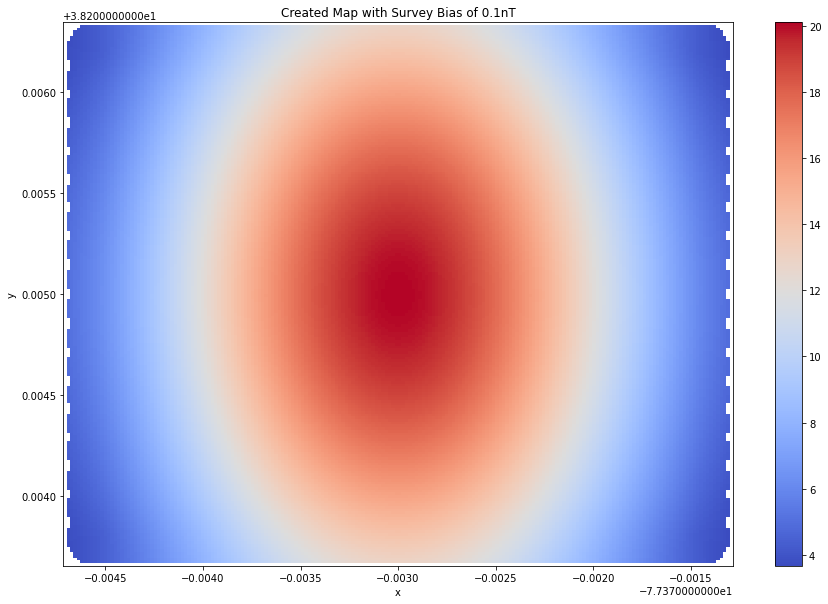

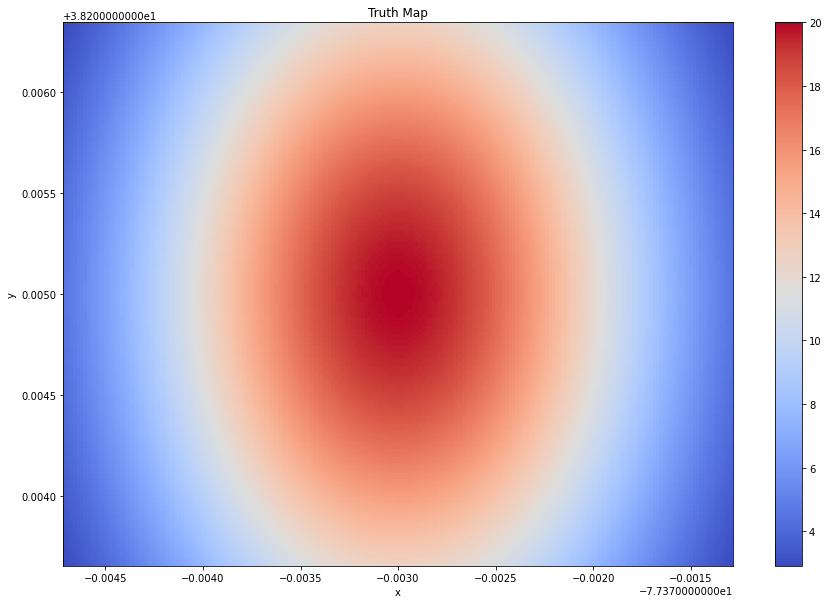

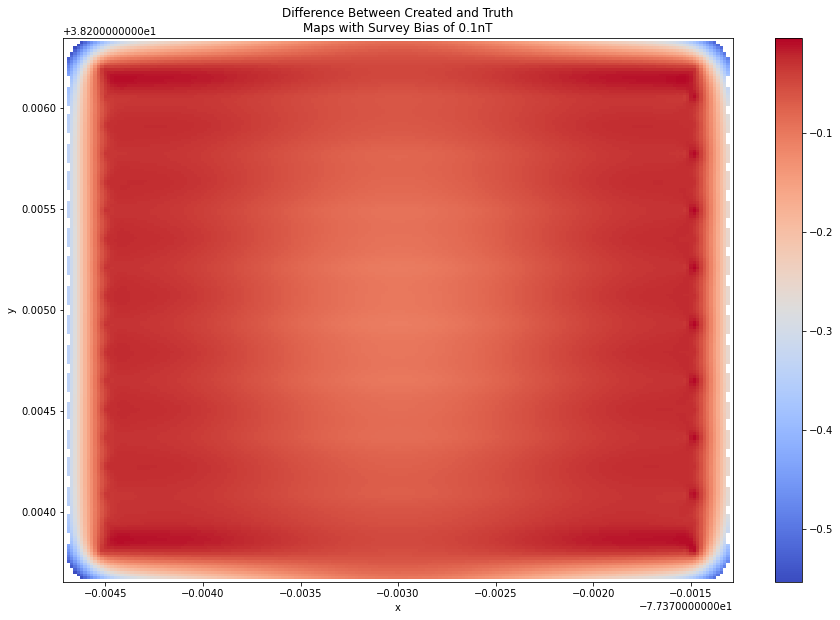

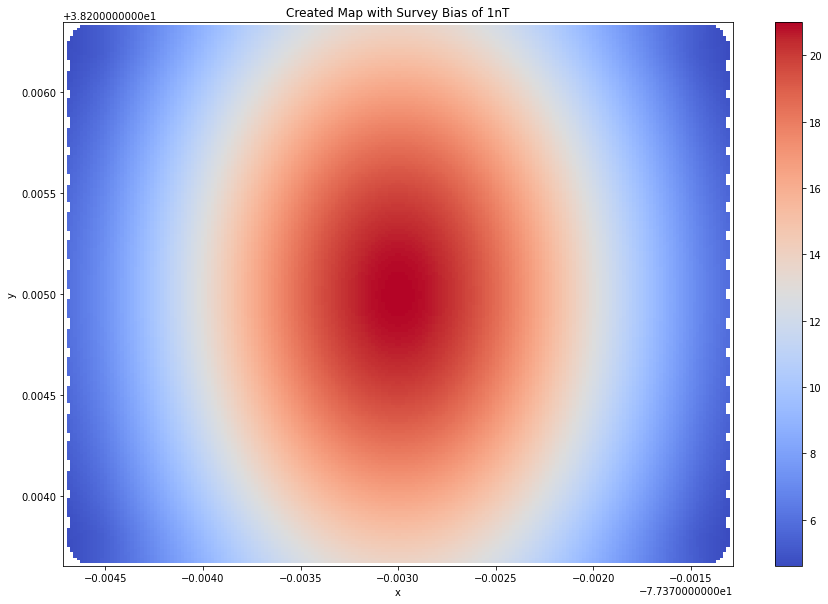

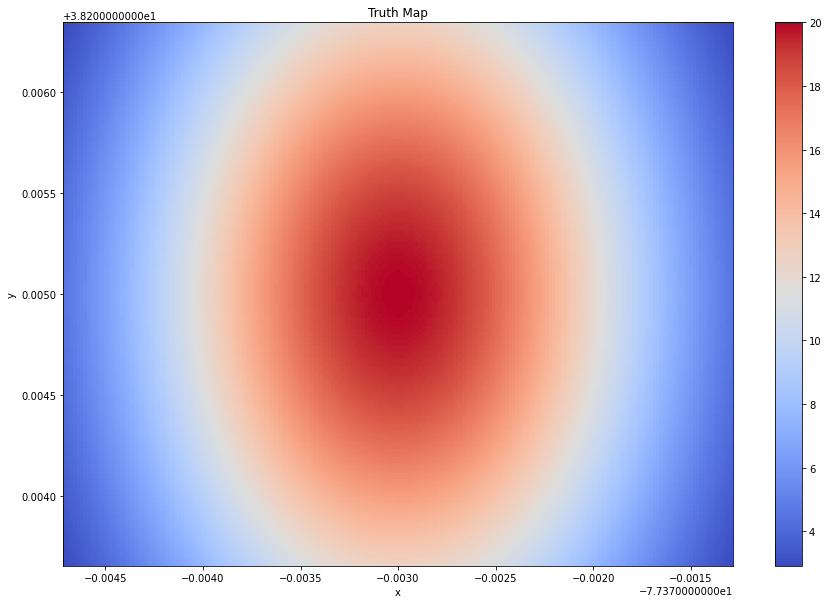

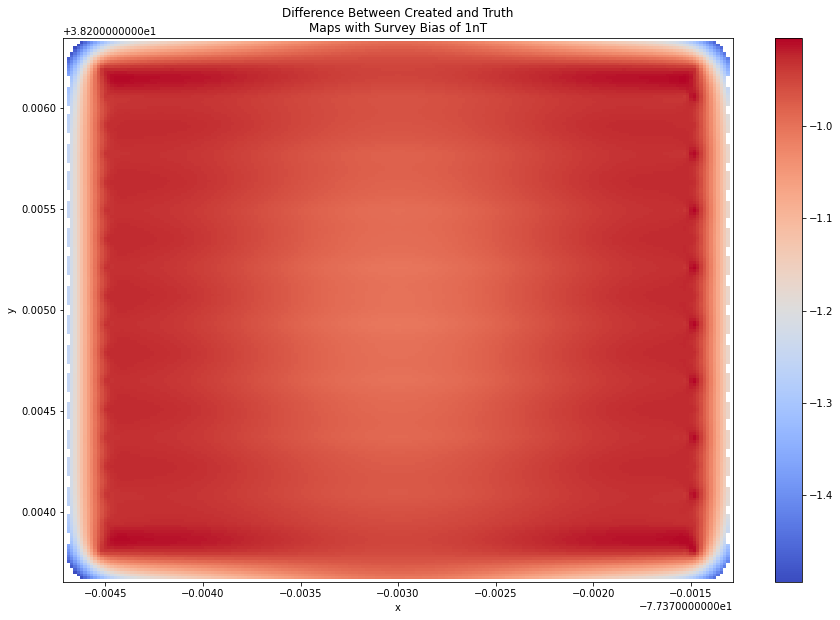

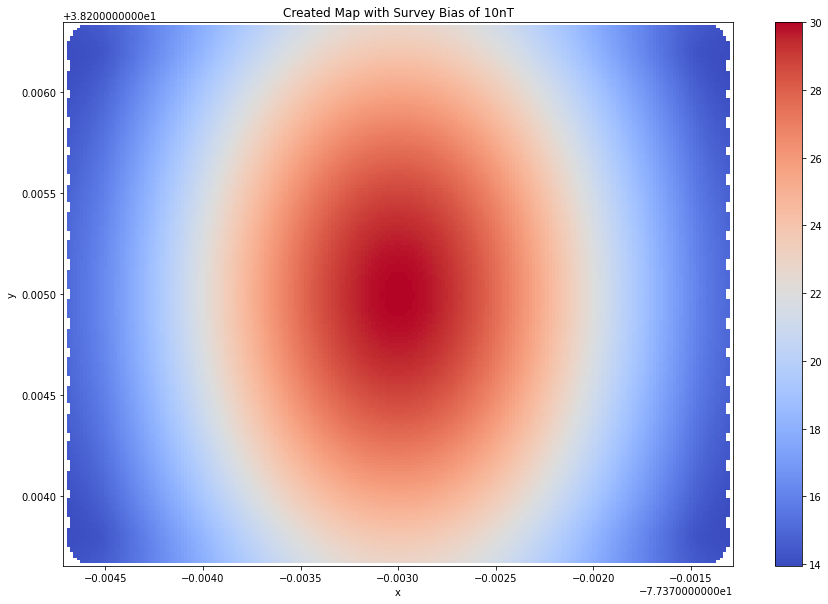

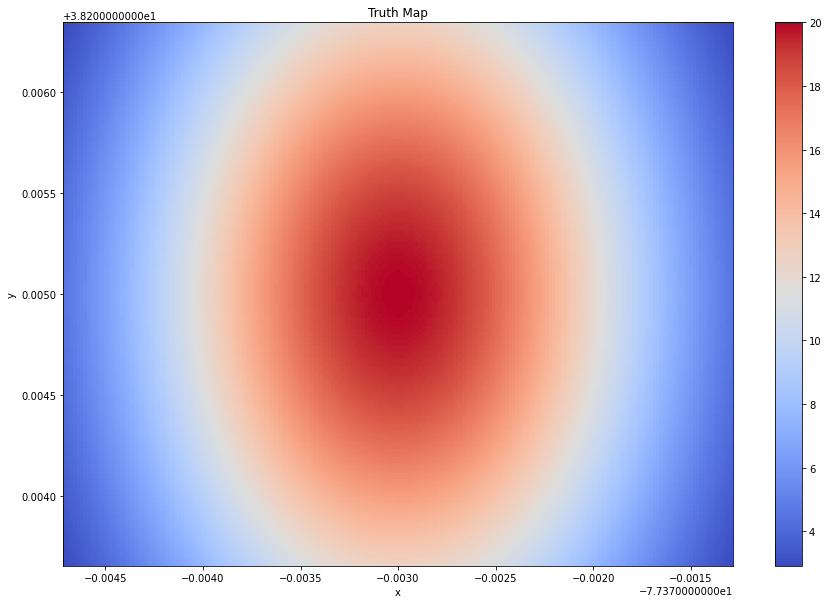

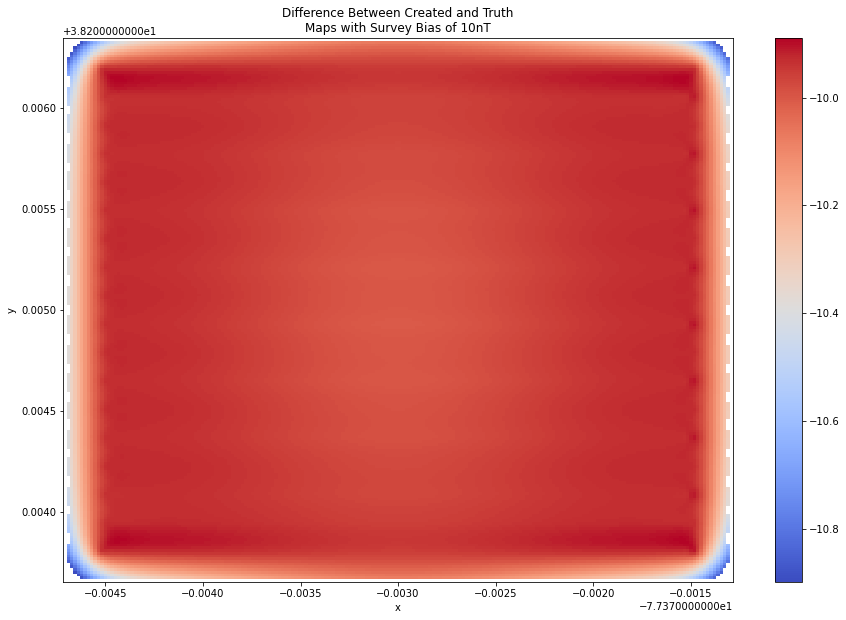

In [24]:
biases    = [0.1, 1, 10]
survey_df = deepcopy(survey.survey_df)

for bias in biases:
    biased_survey_df = deepcopy(survey_df)
    biased_survey_df.F += bias

    survey.map_loc_name = 'reconstructed_{}nT_bias'.format(bias)

    map = survey.gen_map(survey_df=biased_survey_df)

    interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

    plt.figure()
    interp_map.plot(cmap=cm.coolwarm)
    plt.title('Created Map with Survey Bias of {}nT'.format(bias))

    plt.figure()
    truth_map[0].plot(cmap=cm.coolwarm)
    plt.title('Truth Map')

    plt.figure()
    error_map = truth_map[mu.SCALAR] - interp_map
    error_map.plot(cmap=cm.coolwarm)
    plt.title('Difference Between Created and Truth\nMaps with Survey Bias of {}nT'.format(bias))

    map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
    print('Generated scalar map RMSE with survey bias of {}nT: {}nT'.format(bias, map_rmse))

# Generate Map Using Scalar Measurements with Additive White Gaussian Noise (AWGN)

100%|██████████| 39204/39204 [00:02<00:00, 16647.15it/s]


Generated scalar map RMSE with survey AWGN (STD: 1nT): 0.5214322025204605nT


100%|██████████| 39204/39204 [00:02<00:00, 16625.77it/s]


Generated scalar map RMSE with survey AWGN (STD: 10nT): 4.661728818571068nT


100%|██████████| 39204/39204 [00:02<00:00, 16668.05it/s]


Generated scalar map RMSE with survey AWGN (STD: 100nT): 48.39170483060359nT


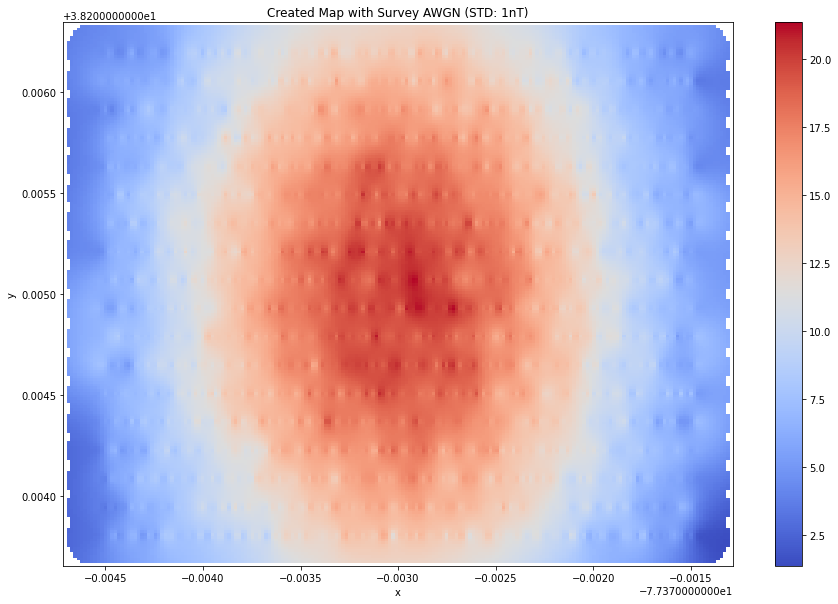

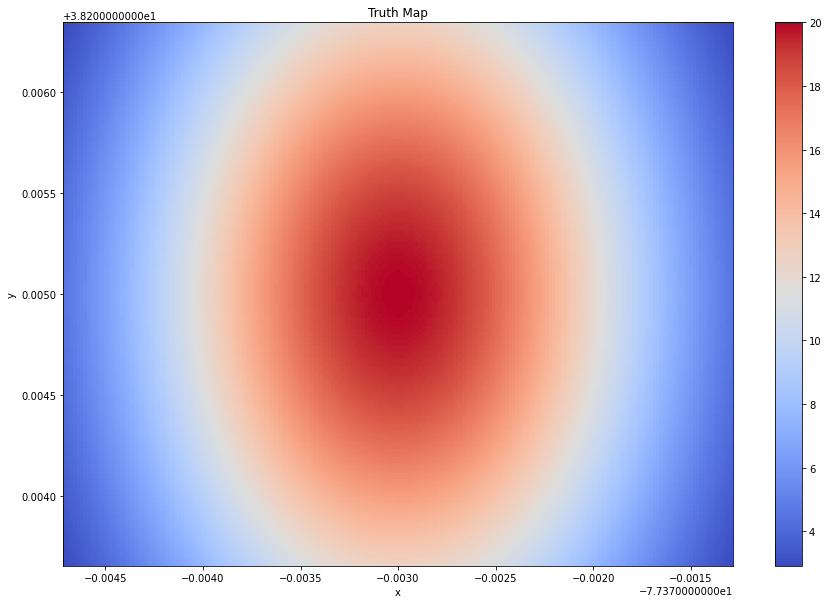

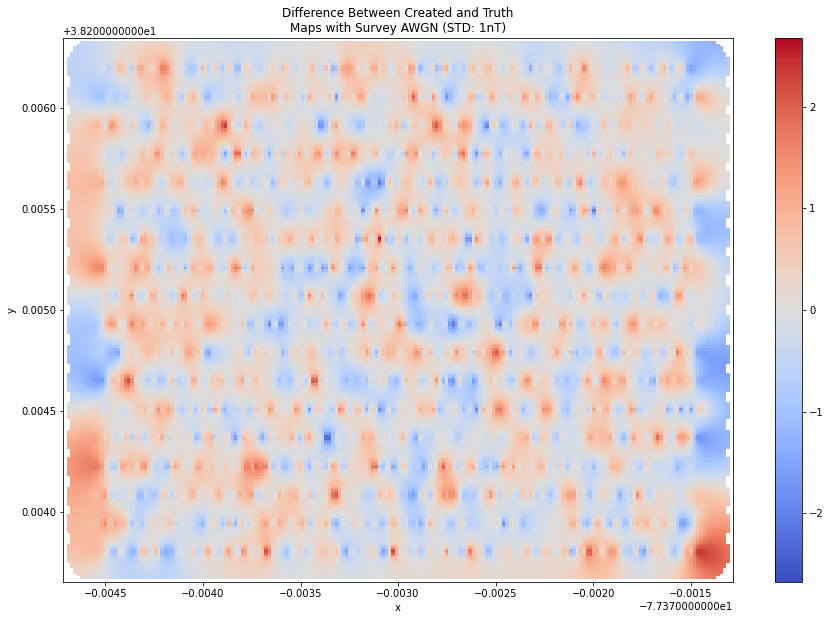

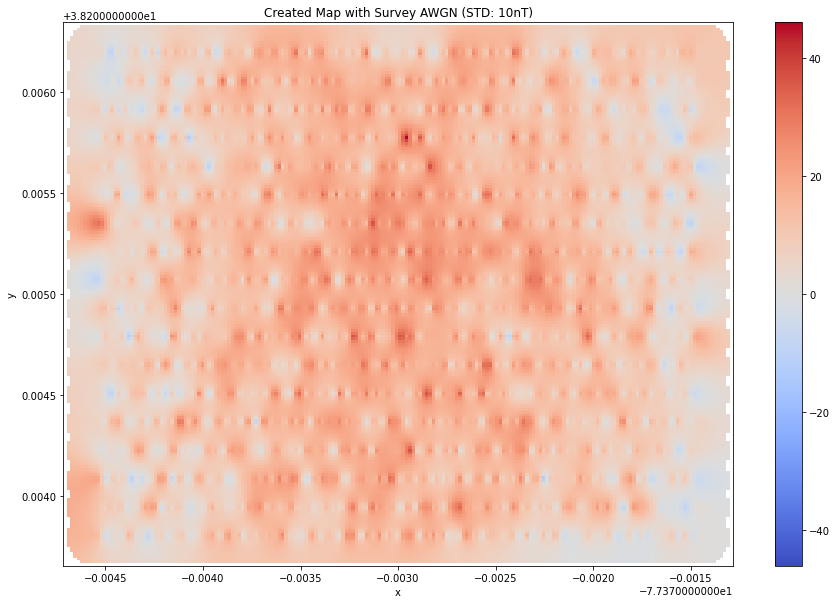

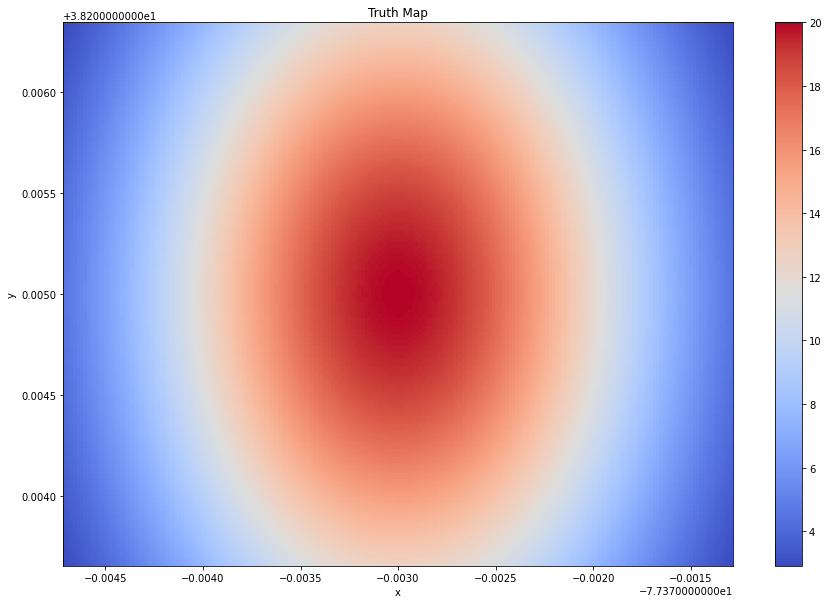

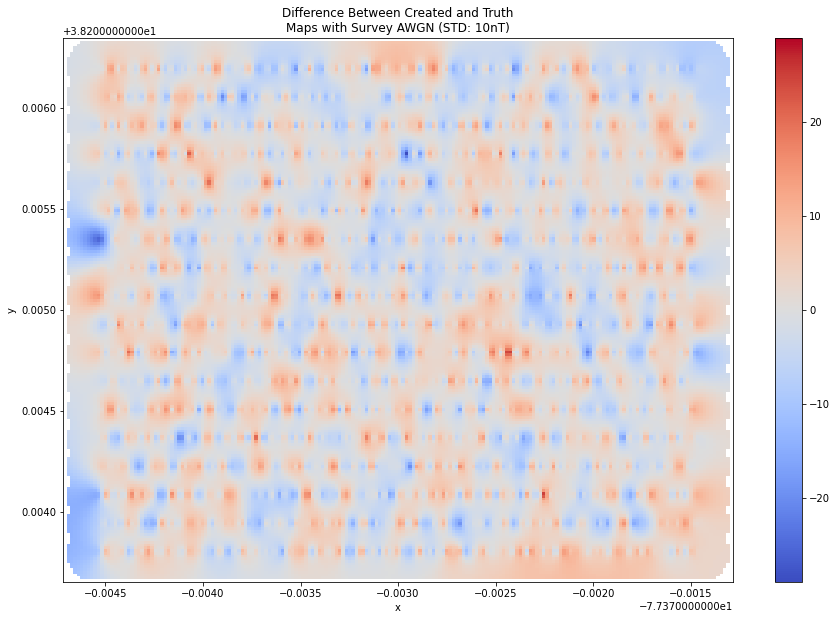

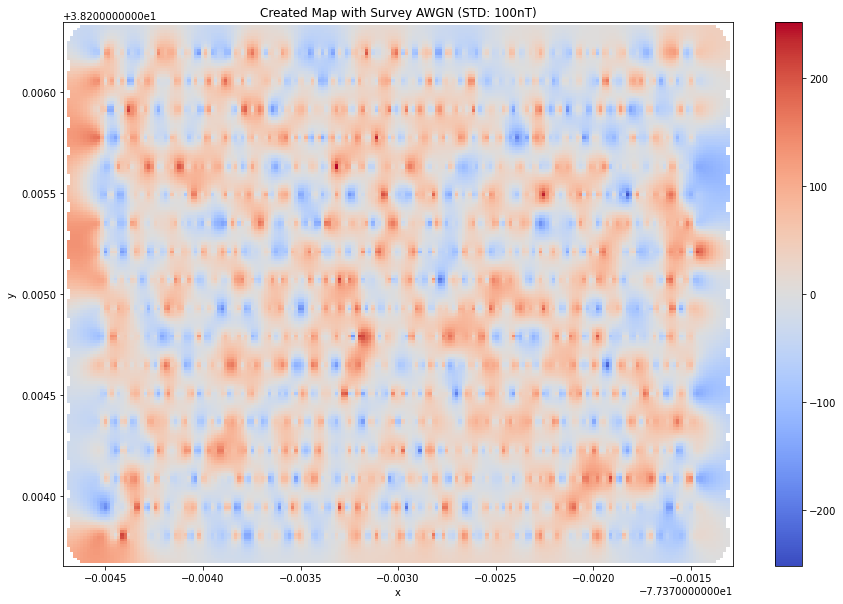

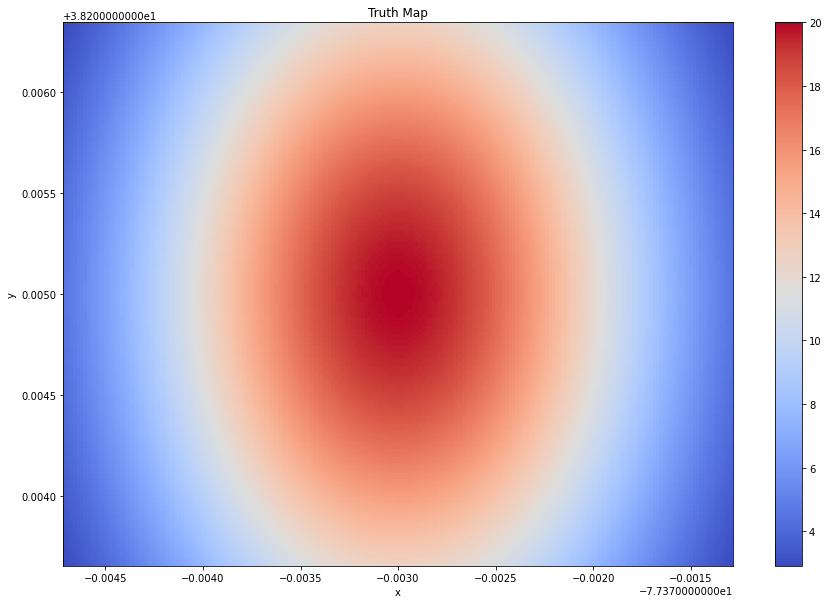

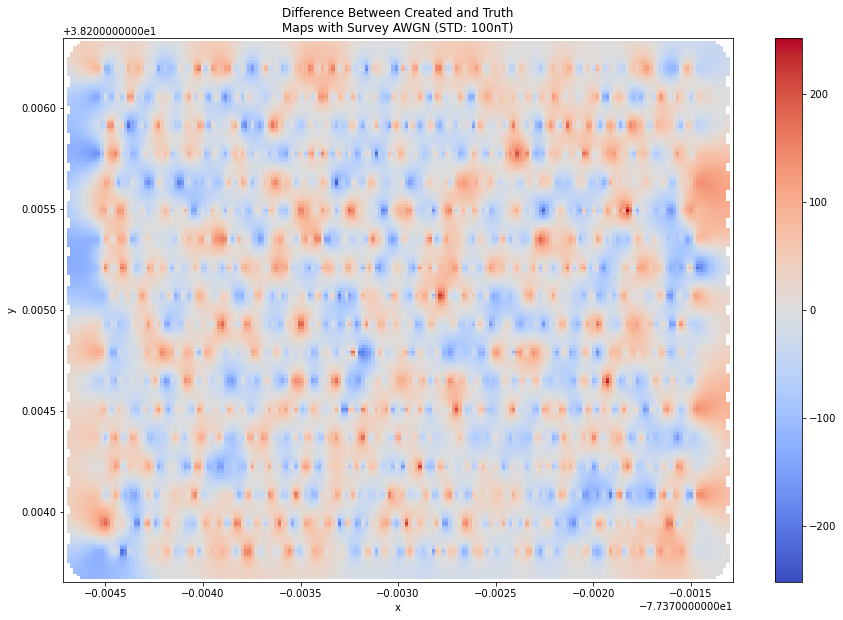

In [25]:
awgn_stds = [1, 10, 100]

for awgn_std in awgn_stds:
    noised_survey_df = deepcopy(survey_df)
    noised_survey_df.F += np.random.randn(len(noised_survey_df.F)) * awgn_std

    map = survey.gen_map(survey_df=noised_survey_df)
    
    interp_map = map[mu.SCALAR].interp(x=truth_map.x, y=truth_map.y)

    plt.figure()
    interp_map.plot(cmap=cm.coolwarm)
    plt.title('Created Map with Survey AWGN (STD: {}nT)'.format(awgn_std))

    plt.figure()
    truth_map[0].plot(cmap=cm.coolwarm)
    plt.title('Truth Map')

    plt.figure()
    error_map = truth_map[mu.SCALAR] - interp_map
    error_map.plot(cmap=cm.coolwarm)
    plt.title('Difference Between Created and Truth\nMaps with Survey AWGN (STD: {}nT)'.format(awgn_std))

    map_rmse = pu.rmse(interp_map.data, truth_map[mu.SCALAR].data)
    print('Generated scalar map RMSE with survey AWGN (STD: {}nT): {}nT'.format(awgn_std, map_rmse))